In [2]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import time

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Data loading and caching

The data from TCGA database is filtered on the website and downloaded from a cart. Downloaded artifacts are:
1. A single archive with raw sample data. This is where the gene expression data is stored.
2. gdc_sample_sheet.{date}.tsv, containing metadata about downloaded samples such as study ID, sample ID, file ID, etc.
3. clinical.tsv, containing clinical metadata about the subject (smoking habbits, treatment, age...) and conditions of the sample collection (instruments, methods...) 

In [14]:
# local paths to the TCGA data
parent_dir = "data/data-tcga/samples"
sample_sheet_file = "data/data-tcga/gdc_sample_sheet.2023-05-20.tsv"
clinical_file = "data/data-tcga/clinical.tsv"

All of the results of expencive processing will be stored in pickle files for quick re-run of the scripts.

In [5]:
# tpm data frame (input)
all_data_file_path = "all_data.pkl"
# origin tissue (groundtruth)
all_labels_file_path = "all_labels.pkl"
# subject's age (metadata)
all_ages_file_path = "all_ages.pkl"
# subject's gender (metadata)
all_genders_file_path = "all_genders.pkl"
# list of gene IDs for which count are available
# these are the column names of our input data frame
all_data_columns_file_path = "all_data_columns.pkl"

# caching for mapping between raw values and target cancer types
# created as a result of the interactive input while reading data (details bellow)
class_mapping_file_path = "class_mapping.pkl"
ignored_tissues_file_path = "ignored_tissues_list.pkl"

## Interactive groundtruth labeling

The information about the cancer type is located in the "tissue_origin" column in clinical.tsv file for each sample. Unfortunately, entries in this column don't have a strict formatting requirements, so each individual contributor had the liberty to label the ttissue origin the way they saw fit.

Our goal is to have a strictrly defined set of 10 cancer types as labels, so we must perform mapping from whatever set of values we find in the data into a one-word class label. To do this we maintain all of the mappings in a single dictionary "class_mapping" and the labels which should be skipped/ignored in a list "ignored_tissues". While reading the samples we use the dictionary as a look-up table to map the raw values into one of our known cancer types. When we hit an unknown value, we ask the user to provide the mapping for it and we store it in the dictionary for the future reference.

These mappings are cached in pickle files, so the mappings don't have to be computed each time when dataset is being reconstructed.

In [19]:
# a dictionary storing the mapping from a raw values found in the sample metadata
# to one of the 10 cancer types
class_mapping = {}
# a list of raw metadata values to be skipped while parsing
ignored_tissues = []

# load the class mapping dictionary and ignore list from the cached pickle files if they exist
if os.path.exists(class_mapping_file_path):
    print("Loading class mappings from cache...")
    # load the list of ignored tissues from a pickel file
    with open(ignored_tissues_file_path, 'rb') as f: 
        ignored_tissues = pickle.load(f)

    # load a dataframe with the labels of each sample from a pickel file
    with open(class_mapping_file_path, 'rb') as f: 
        class_mapping = pickle.load(f)
print(class_mapping)

Loading class mappings from cache...
{}


In [7]:
# verify if the data cache exists...
if not os.path.exists(all_data_file_path):
    
    # ...it doesn't, we must parse the data

    # read sample sheet file and clinical file into the memory
    sample_sheet = pd.read_csv(sample_sheet_file, delimiter="\t")
    clinical_sheet = pd.read_csv(clinical_file, delimiter="\t")
    
    # lists for accumulating the data as we're going through the folders one by one
    all_data = []
    all_labels = []
    all_ages = []
    all_genders = []

    # iterate through all folders in the parent directory
    for folder in os.listdir(parent_dir):

        # Create the full path to the folder
        folder_path = os.path.join(parent_dir, folder)
        # Check if the item in the directory is a folder
        if os.path.isdir(folder_path):

            # try to extract the cancer tissue first, if possible
            row = sample_sheet[ sample_sheet['File ID'] == folder ]
            
            # confirm that there is at most 1 row extracted for the current folder
            assert(row.shape[0] < 2)

            # access the value stored in Case ID
            case_id = row['Case ID'].values[0]

            case_id_clinical = clinical_sheet[clinical_sheet['case_submitter_id'] == case_id]
            if len(case_id_clinical['tissue_or_organ_of_origin'].values) == 0:
                continue

            tissue_organ_origin = case_id_clinical['tissue_or_organ_of_origin'].values[0]

            # skipping the labels stored in ignored_tissue list:
            if tissue_organ_origin in ignored_tissues:
                continue

            # storing the label mappings in a dictionary
            if tissue_organ_origin not in class_mapping:
                new_label = None
                # try to find an already seen label in tissue_organ_origin automatically
                for label in all_labels:
                    # converting label from dataframe to string
                    label = label[0][0]
                    if label in tissue_organ_origin.lower():
                        new_label = label
                        break
                # manual user input required to determine the label
                if new_label is None:
                    print(f'New tissue origin found: \"{tissue_organ_origin}\". \nEnter the label for it or leave it empty to add it to the ignore list: ')
                    time.sleep(1)
                    new_label = input()

                    if new_label == "":
                        # user didn't provide any input, meaning we should skip this sample
                        ignored_tissues.append(tissue_organ_origin)
                        continue
                class_mapping[tissue_organ_origin] = new_label

            # tissue extracted successfully!
            all_labels.append(pd.DataFrame([class_mapping[tissue_organ_origin]]))

            # pick up some metadata for the current sample so we have it for further analysis
            age = case_id_clinical['age_at_index'].values[0]
            all_ages.append(pd.DataFrame([age]))
            gender = case_id_clinical['gender'].values[0]
            all_genders.append(pd.DataFrame([gender]))

            # extract the gene counts

            # Get a list of all .tsv files in the folder
            tsv_files = [f for f in os.listdir(folder_path) if f.endswith('.tsv')]
            # If there is exactly one .tsv file in the folder, proceed
            if len(tsv_files) == 1:
                # Create the full path to the .tsv file
                tsv_path = os.path.join(folder_path, tsv_files[0])
                
                # Open the .tsv file and count the number of lines starting with "ENSG"
                columns = []
                counts = []
                with open(tsv_path, 'r') as tsv_file:
                    for line in tsv_file:
                        if line.startswith("ENSG"):

                            split_line = line.split('\t')

                            gene_name = split_line[1]
                            tpm = split_line[6]
                            columns.append(gene_name)
                            counts.append(tpm)

                row_df = pd.DataFrame(counts, dtype=np.float32)
                all_data.append(row_df)

    print("Tissue and counts extracted sucessfully!")

    all_data = pd.concat(all_data, axis=1, ignore_index=True).transpose()
    all_data.columns = columns
    all_labels = pd.concat(all_labels, axis=0, ignore_index=True)
    all_ages = pd.concat(all_ages, axis=0, ignore_index=True)
    all_genders = pd.concat(all_genders, axis=0, ignore_index=True)

    # store the count matrices, labels and metadata into pickle files
    with open(all_data_file_path, 'wb') as f:
        pickle.dump(all_data, f)
    with open(all_labels_file_path, 'wb') as f:
        pickle.dump(all_labels, f)
    with open(all_genders_file_path, 'wb') as f:
        pickle.dump(all_genders, f)
    with open(all_ages_file_path, 'wb') as f:
        pickle.dump(all_ages, f)
    

else: # .pkl file exists, load everything from it to skip processing

    with open(all_data_file_path, 'rb') as f:
        all_data = pickle.load(f)
    with open(all_labels_file_path, 'rb') as f:
        all_labels = pickle.load(f)
    with open(all_genders_file_path, 'rb') as f:
        all_genders = pickle.load(f)
    with open(all_ages_file_path, 'rb') as f:
        all_ages = pickle.load(f)

In [12]:
# save the class mapping cache if they do not exist
with open(ignored_tissues_file_path, 'wb') as f: 
    pickle.dump(ignored_tissues, f)
with open(class_mapping_file_path, 'wb') as f: 
    pickle.dump(class_mapping, f)

# Exploratory Data Analysis

Let's introspect our dataset.

In [20]:
print(f'Total number of samples: {all_data.shape[0]}')

# save the all_data columns in a list
all_data_columns = all_data.columns
print('all_data_columns: ', all_data_columns)
print(f'Total gene count: {len(all_data_columns)}')
unique_columns = list(set(all_data_columns))
print(f'Unique gene count: {len(unique_columns)}')

# save the columns to use it later to organize the columns of different dataset
with open(all_data_columns_file_path, 'wb') as all_data_columns_pckl: 
    pickle.dump(unique_columns, all_data_columns_pckl)

Total number of samples: 8668
all_data_columns:  Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2',
       'GCLC', 'NFYA',
       ...
       'AL451106.1', 'AC092910.4', 'AC073611.1', 'AC136977.1', 'AC078856.1',
       'AC008763.4', 'AL592295.6', 'AC006486.3', 'AL391628.1', 'AP006621.6'],
      dtype='object', length=60660)
Total gene count: 60660
Unique gene count: 59427


We can see we have 8668 samples and 60660 features (gene TPM values), out of which 59427 are unique. It is important to remove duplicated columns since this is one of the requirements for model building step.

The way we will perform the "removal" is by summing the columns with the same name. This is methodologically correct because TPM values are distributive. 

In other words TPM(A+B) = TPM(A) + TPM(B).

In [21]:
all_data_unique = all_data.groupby(all_data.columns, axis=1).sum()
print(f'Total gene count: {len(all_data_unique.columns)}')
unique_columns = len(set(all_data_unique.columns))
print(f'Unique gene count: {unique_columns}')
print(all_data_unique.shape)
print(all_labels.shape)

Total gene count: 59427
Unique gene count: 59427
(8668, 59427)
(8668, 1)


We see we don't have any duplicated features, so we can proceed with the further analysis.

Let's construct the joint dataframe with labels (cancer types) as the last column.

In [24]:
data = pd.concat([all_data_unique, all_labels], axis=1)
print(data.head(3))
print(data[data.columns[-1]])

   5S_rRNA  5_8S_rRNA        7SK    A1BG  A1BG-AS1     A1CF          A2M   
0   5.6912        0.0  66.004196  0.1532    0.6227  25.4995   505.514191  \
1   2.7205        0.0   0.000000  0.1082    1.8803   0.0000   257.103607   
2   0.0000        0.0   0.000000  0.3233    1.7982   0.0207  1037.928955   

   A2M-AS1   A2ML1  A2ML1-AS1  ...  ZYG11AP1     ZYG11B         ZYX  ZYXP1   
0   4.3358  0.3059     0.1937  ...    0.2092  48.596298   11.228200    0.0  \
1   0.0245  0.0705     0.0000  ...    0.0000   8.486600  156.321106    0.0   
2   3.3739  0.2502     0.0000  ...    0.0000  24.120100  308.524292    0.0   

       ZZEF1     ZZZ3  hsa-mir-1253  hsa-mir-423  snoZ196       0  
0  30.483101  42.7341           0.0          0.0   0.9837  kidney  
1  17.201700  15.2780           0.0          0.0   0.8100    skin  
2  16.846201  22.9774           0.0          0.0   1.1176  breast  

[3 rows x 59428 columns]
0       kidney
1         skin
2       breast
3       kidney
4         lung
         

# Dataset distribution

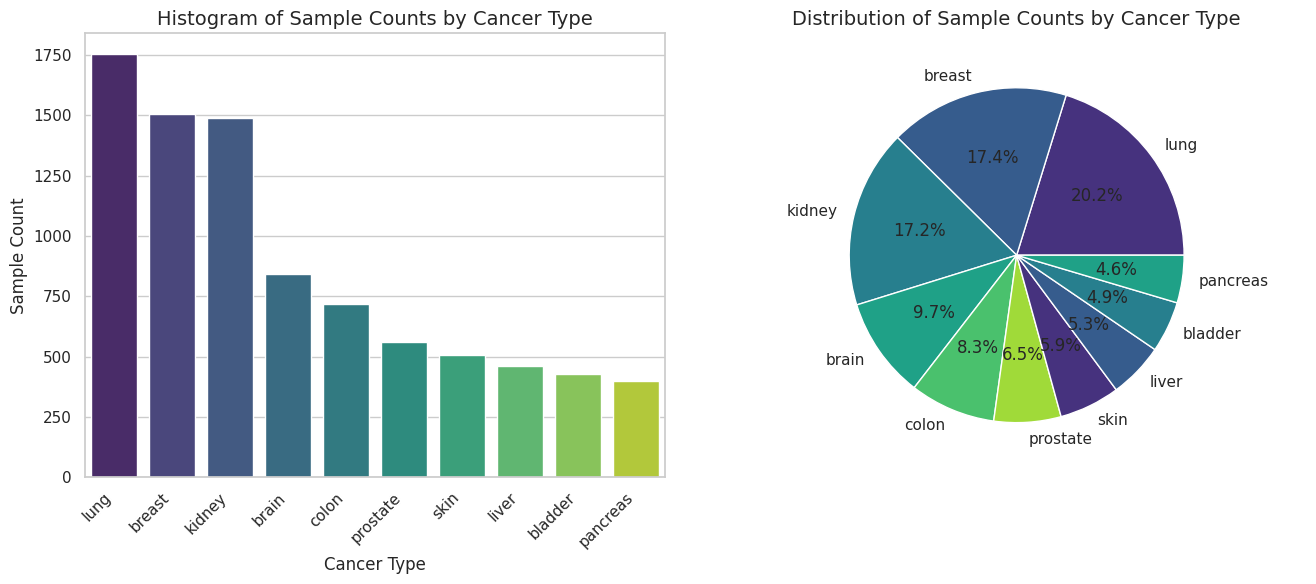

In [10]:
# Get the label column name
label_column = data.columns[-1]

# Count the samples for each cancer type
sample_counts = data[label_column].value_counts()

# Set the seaborn style
sns.set(style="whitegrid")

# Create the figure and axes for both subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the bar plot
bar_plot = sns.barplot(x=sample_counts.index, y=sample_counts.values, palette="viridis", ax=ax1)
bar_plot.set_xlabel('Cancer Type', fontsize=12)
bar_plot.set_ylabel('Sample Count', fontsize=12)
bar_plot.set_title('Histogram of Sample Counts by Cancer Type', fontsize=14)
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, ha="right")

# Plotting the pie chart
pie_plot = ax2.pie(sample_counts.values, labels=sample_counts.index, autopct='%1.1f%%', colors=sns.color_palette("viridis"), startangle=00)
ax2.set_title('Distribution of Sample Counts by Cancer Type', fontsize=14)
ax2.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle

# Adjust the spacing between titles and charts
plt.subplots_adjust(top=1.1)  # Increase the top margin

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

We can see that our dataset is slightly disbalanced, where lung, breast and kidney are the most represented classes.

## Subject age distribution

/tmp/ipykernel_3478274/888689315.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=45, ha="right")


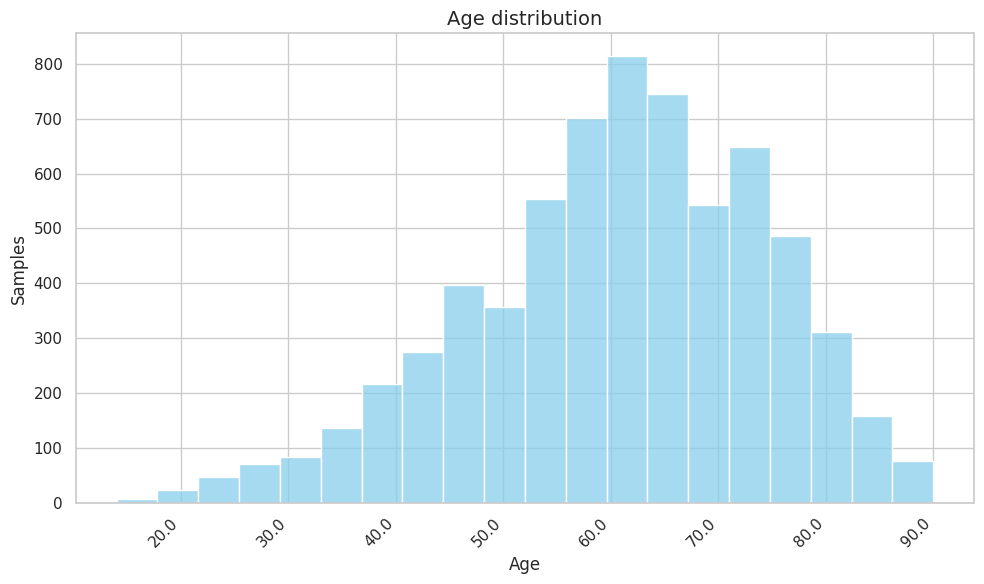

In [11]:
# Extract valid numerical ages
valid_ages = pd.to_numeric(all_ages[0], errors='coerce').dropna()

# Set the seaborn style
sns.set(style="whitegrid")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the histogram
sns.histplot(valid_ages, bins=20, color='skyblue', edgecolor='white', ax=ax)

# Customize the labels and title
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Samples', fontsize=12)
ax.set_title('Age distribution', fontsize=14)

# Rotate and align x-axis labels
ax.set_xticklabels(ax.get_xticks(), rotation=45, ha="right")

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Data visualization

We will visualize our dataset by projecting it from 60660-dimensional space to 2-dimensional space and plotting each sample as an individual data point. hopefully this will give us some intuition on separability of our data.

We will apply two dimensionality reduction techniques:
1. PCA
2. t-SNE

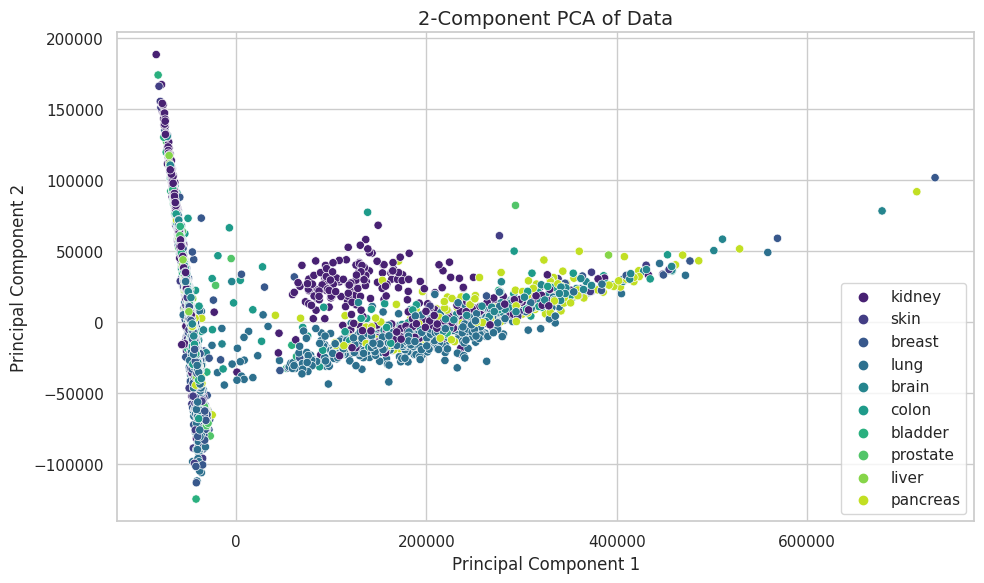

In [27]:
# Separate the features and labels
features = data.iloc[:, :-1]
labels = data.iloc[:, -1]

# Perform PCA
pca = PCA(n_components=2)
components = pca.fit_transform(features)

# Create a new DataFrame with the principal components and labels
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
pca_df['Label'] = labels

# Set the seaborn style
sns.set(style="whitegrid")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the PCA components
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Label', palette='viridis', ax=ax)

# Customize the labels and title
ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)
ax.set_title('2-Component PCA of Data', fontsize=14)

# Display the legend
ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

The first two PCA components don't seem to be good indicators of the cancer type. The only partially distinguishable label is "kidney", while the rest of the cancer types are too clustered to reveal any kind of useful separation.

Going beyond two PCA components might help, but high dimensionality of the original dataset (approx 60.000 feaures) is memory prohibitive for a consumer machine. In order to perform higher dimensionality PCA we could perform feature selection beforehand.

# t-SNE

In [28]:
# Separate the features and labels
features = data.iloc[:, :-1]
labels = data.iloc[:, -1]

# Convert labels to numeric values
label_values, label_mapping = pd.factorize(labels)

# Perform t-SNE analysis
tsne = TSNE(n_components=2, random_state=42)
embeddings = tsne.fit_transform(features)

label_mapping_df = pd.DataFrame({"label":label_mapping, "index":range(len(label_mapping))})
label_mapping_df

,label,index
0,kidney,0
1,skin,1
2,breast,2
3,lung,3
4,brain,4
5,colon,5
6,bladder,6
7,prostate,7
8,liver,8
9,pancreas,9


/tmp/ipykernel_3478274/3936360562.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab10', num_labels)


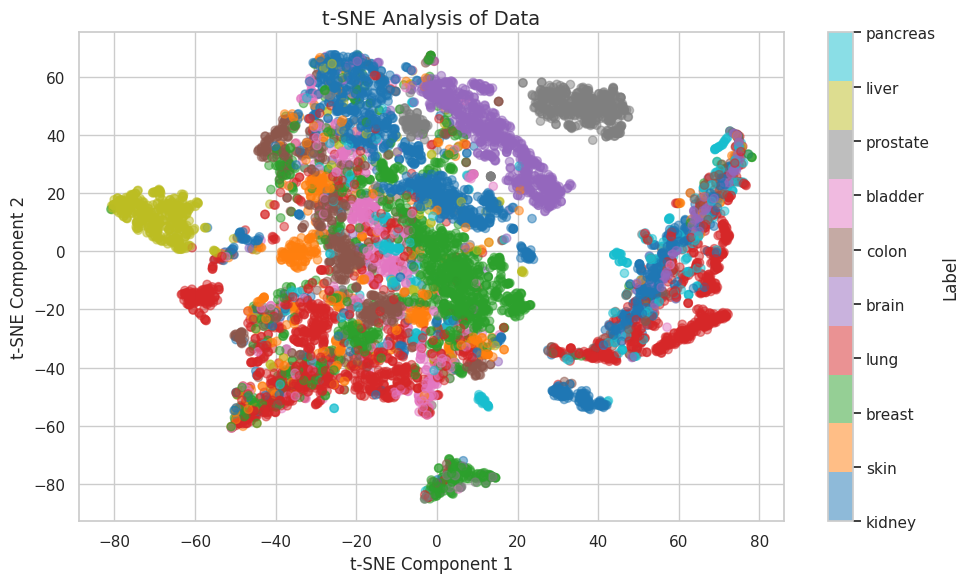

In [26]:
# Create a new DataFrame with the t-SNE embeddings and numeric labels
tsne_df = pd.DataFrame(data=embeddings, columns=['TSNE1', 'TSNE2'])
tsne_df['Label'] = label_values

# Create a custom color map with 10 distinguishable colors
num_labels = len(label_mapping)
color_map = cm.get_cmap('tab10', num_labels)

# Create the scatter plot of the t-SNE embeddings
plt.figure(figsize=(10, 6))
scatter_plot = plt.scatter(x=tsne_df['TSNE1'], y=tsne_df['TSNE2'], c=tsne_df['Label'], cmap=color_map, alpha=0.5)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title('t-SNE Analysis of Data', fontsize=14)

# Customize the legend with actual label mappings
legend_labels = [label_mapping[i] for i in range(num_labels)]
plt.colorbar(scatter_plot, label='Label', ticks=range(num_labels)).set_ticklabels(legend_labels)

plt.tight_layout()
plt.show()

## Interpretation of t-SNE

As we can see, liver, prostate and brain cancers are clearly separable based on their gene expression data (no other cancer types in their cluster).

Kidney, lung and breast cancer have at least two big separable clusters, indicating there exists some kind of common modality affecting the gene expression profiles in the same way between group of samples. One explanation might be cancer patient with or without treatment.

Lastly, we can identify a cluster with lung and kidney cancer types "behaving" the same way even though they. This could be an indicator of a common clinical property for patients between different cancer types, such as smoking habbits or alchohol consumption.

In order to do this, we first have to isolate the samples belonging to the cluster on the right. To do that we'll perform K-means clustering on the output of t-SNE.

/home/rubi/RNA-seq-cancer-detector/RNA-seq-cancer-classification/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


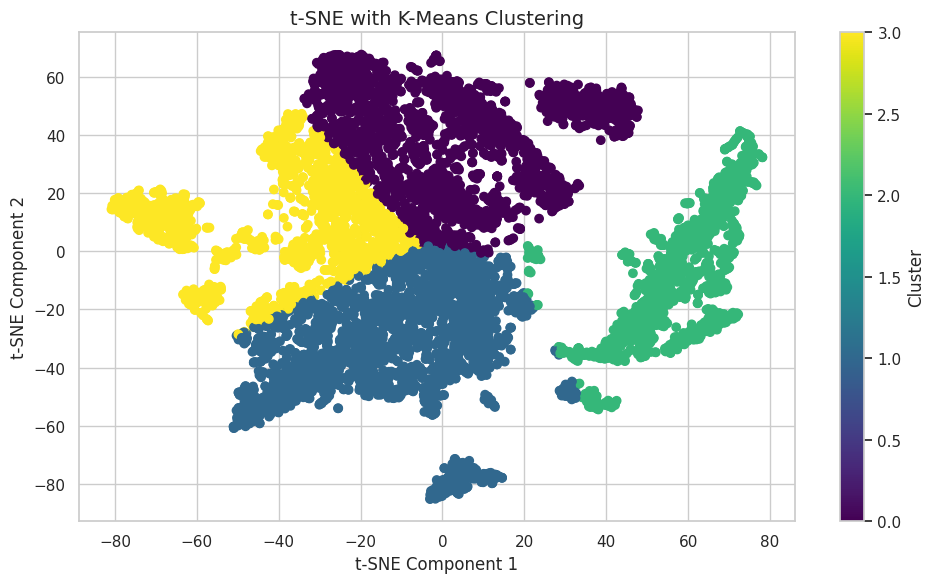

In [40]:
# Perform k-means clustering on the t-SNE embeddings
num_clusters = 4  # Specify the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Create a new DataFrame with the t-SNE embeddings and cluster assignments
tsne_df = pd.DataFrame(data=embeddings, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = cluster_labels

# Plot t-SNE with colored clusters
plt.figure(figsize=(10, 6))
scatter_plot = plt.scatter(x=tsne_df['TSNE1'], y=tsne_df['TSNE2'], c=tsne_df['Cluster'], cmap='viridis')
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title('t-SNE with K-Means Clustering', fontsize=14)
plt.colorbar(scatter_plot, label='Cluster')
plt.tight_layout()
plt.show()

For K=4 clusters we get a clustering shown above, with green cluster (labeled with "2") shows a pretty good coverage of the cluster we want to analyze.

Now we are in a position to extract the samples corresponding to the cluster 2, since we have their indices. We will select only those points and plot the t-SNE graph with only those to confirm we have a good selection.

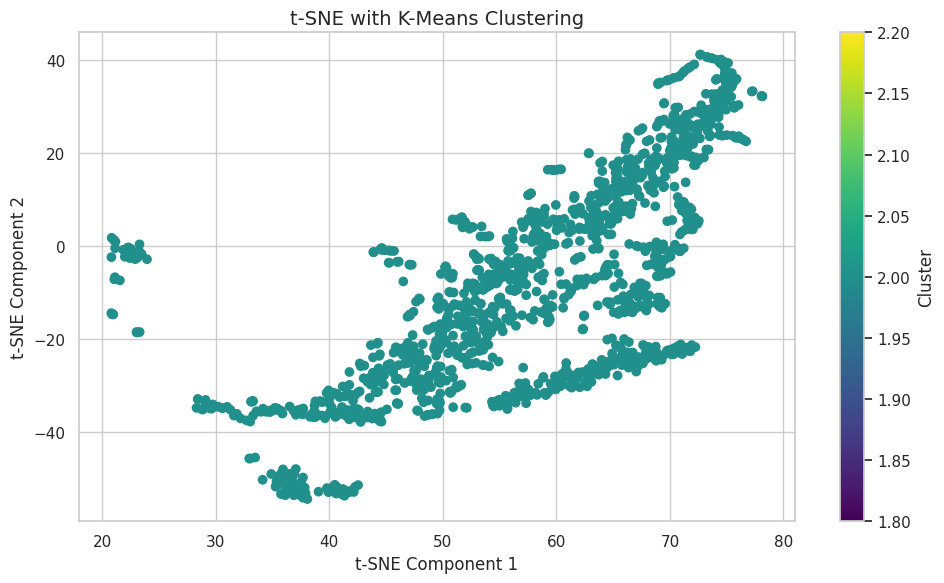

In [43]:
cluster_2_idx = tsne_df["Cluster"] == 2
cluster_2 = tsne_df[cluster_2_idx]

# Plot t-SNE with colored clusters
plt.figure(figsize=(10, 6))
scatter_plot = plt.scatter(x=cluster_2['TSNE1'], y=cluster_2['TSNE2'], c=cluster_2['Cluster'], cmap='viridis')
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title('t-SNE with K-Means Clustering', fontsize=14)
plt.colorbar(scatter_plot, label='Cluster')
plt.tight_layout()
plt.show()

130     59.0
142     64.0
441     46.0
567     60.0
593     74.0
        ... 
8199    64.0
8255    43.0
8314    69.0
8340    74.0
8352    65.0
Name: 0, Length: 126, dtype: float64


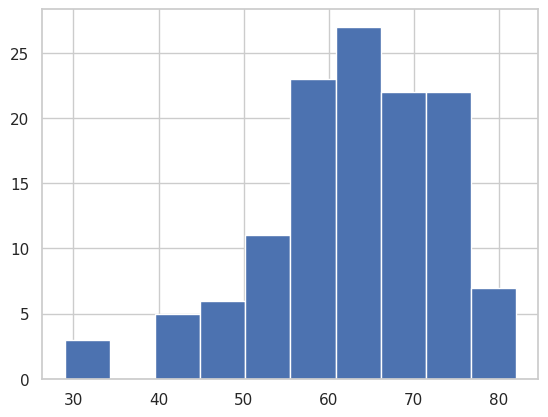

In [53]:

all_data_cluster_2 = all_data_unique[cluster_2_idx]
age_cluster_2 = all_ages[cluster_2_idx]
valid_ages = pd.to_numeric(age_cluster_2[0], errors='coerce').dropna()

plt.hist(valid_ages)
print(valid_ages)

Cluster not determined by age, checking further.

In [57]:
all_data_cluster_2 = all_data_unique[cluster_2_idx]
gender_cluster_2 = all_genders[cluster_2_idx]
sample_counts = gender_cluster_2[0].T.value_counts()

print(sample_counts)

0
male      976
female    594
Name: count, dtype: int64
